## Import modules

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [ ]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import to_categorical
from keras.datasets import cifar10

from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam


# Get Inception architecture from keras.applications
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


## Reading data

In [3]:
def load_cifar10(resize=False):
    train = np.load('/nfsroot/data/home/datasets/cse_7321c/cifar10/cifar_train.npz')
    x_train = train['data']
    y_train = train['labels']

    test = np.load('/nfsroot/data/home/datasets/cse_7321c/cifar10cifar_test.npz')
    x_test = test['data']
    y_test = test['labels']
    
    if resize:
        x_train=resize_all(x_train, resize)
        x_test=resize_all(x_test, resize)
    
    x_train = x_train.astype('float32')/255.
    x_test = x_test.astype('float32')/255.
    
    return(x_train, y_train, x_test, y_test)


def resize(p, size):
    return Image.fromarray(p).resize(size=(size,size))

def resize_all(arr, size):
    t = []
    for i in range(arr.shape[0]):
        t.append(np.array(resize(arr[i], size)))
        
#     t = np.array(t, dtype='float32')
#     t /= 255.

    return(np.array(t))

In [4]:
batch_size = 64
nb_classes = 10

img_rows, img_cols = 32, 32    # input image dimensions
img_channels = 3               # The CIFAR10 images are RGB.

In [5]:
(x_train, train_labels), (x_test, test_labels) = cifar10.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

y_train = to_categorical(train_labels, nb_classes)
y_test = to_categorical(test_labels, nb_classes)

## Plot a few train images

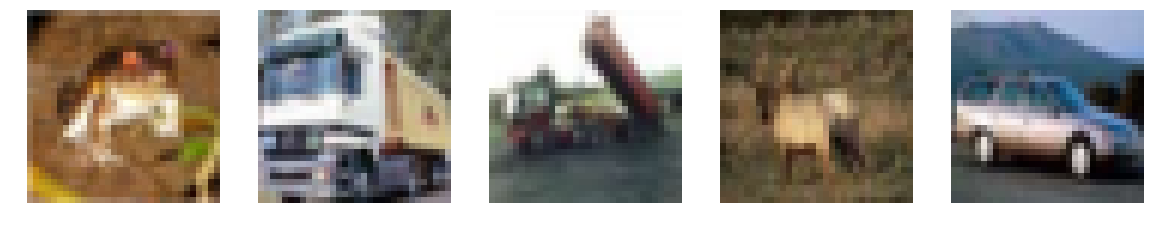

In [6]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

## Custom Network

In [7]:
def custom_convnet(nb_classes, learn_rate, inp_shape):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='same', # valid
                            input_shape=inp_shape, 
                            activation='relu'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    
    adam = Adam(lr=learn_rate)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    
    return(model)


With a lot of samples

In [8]:
model = custom_convnet(nb_classes=10, learn_rate=0.001, inp_shape=(img_rows,img_cols,img_channels))
model.fit(x_train[:50000], y_train[:50000],
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)

model.save('cifar10_savedmodel.h5')          # Saves the weights along with the graph
# model.save_weights('cifar10_savedmodel.h5')  # Saves the weights only

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 11s 220us/step - loss: 1.4913 - acc: 0.4584 - val_loss: 1.1425 - val_acc: 0.5962
Epoch 2/5
50000/50000 [==============================] - 7s 138us/step - loss: 1.0308 - acc: 0.6380 - val_loss: 0.9776 - val_acc: 0.6567
Epoch 3/5
50000/50000 [==============================] - 7s 138us/step - loss: 0.8410 - acc: 0.7079 - val_loss: 0.8092 - val_acc: 0.7197
Epoch 4/5
50000/50000 [==============================] - 7s 146us/step - loss: 0.7148 - acc: 0.7507 - val_loss: 0.7493 - val_acc: 0.7448
Epoch 5/5
50000/50000 [==============================] - 7s 150us/step - loss: 0.6255 - acc: 0.7816 - val_loss: 0.7017 - val_acc: 0.7620


With limited samples

In [9]:
model = custom_convnet(nb_classes=10, learn_rate=0.001, inp_shape=(img_rows,img_cols,img_channels))
model.fit(x_train[:5000], y_train[:5000],
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=15)

Train on 5000 samples, validate on 10000 samples
Epoch 1/15
5000/5000 [==============================] - 2s 346us/step - loss: 2.0805 - acc: 0.2138 - val_loss: 1.8714 - val_acc: 0.3090
Epoch 2/15
5000/5000 [==============================] - 1s 235us/step - loss: 1.7375 - acc: 0.3558 - val_loss: 1.6684 - val_acc: 0.3994
Epoch 3/15
5000/5000 [==============================] - 1s 219us/step - loss: 1.5797 - acc: 0.4200 - val_loss: 1.5731 - val_acc: 0.4252
Epoch 4/15
5000/5000 [==============================] - 1s 241us/step - loss: 1.4549 - acc: 0.4716 - val_loss: 1.4245 - val_acc: 0.4838
Epoch 5/15
5000/5000 [==============================] - 1s 235us/step - loss: 1.3484 - acc: 0.5212 - val_loss: 1.4584 - val_acc: 0.4871
Epoch 6/15
5000/5000 [==============================] - 1s 237us/step - loss: 1.2348 - acc: 0.5594 - val_loss: 1.3188 - val_acc: 0.5290
Epoch 7/15
5000/5000 [==============================] - 1s 240us/step - loss: 1.1144 - acc: 0.5982 - val_loss: 1.2830 - val_acc: 0.5446

## Pre-Trained Network

Resize all the images 

In [10]:
(x_train, train_labels), (x_test, test_labels) = cifar10.load_data()
size=224
x_train=resize_all(x_train, size)
x_test=resize_all(x_test, size)

x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

y_train = to_categorical(train_labels, nb_classes)
y_test = to_categorical(test_labels, nb_classes)

In [11]:
def inception_tl(nb_classes, freez_wts=True, learn_rate=0.001):
    trained_model = InceptionV3(include_top=False,weights='imagenet')
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    pred_inception= Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_inception)
    
    for layer in trained_model.layers:
        layer.trainable=(1-freez_wts)
    
    adam = Adam(lr=learn_rate)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    
    return(model)

In [12]:
model = inception_tl(nb_classes=nb_classes, freez_wts=True)
model.fit(x_train[:5000], y_train[:5000],
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)

Train on 5000 samples, validate on 10000 samples
Epoch 1/5
5000/5000 [==============================] - 44s 9ms/step - loss: 1.6226 - acc: 0.4756 - val_loss: 1.1381 - val_acc: 0.6340
Epoch 2/5
5000/5000 [==============================] - 43s 9ms/step - loss: 1.0340 - acc: 0.6802 - val_loss: 1.1295 - val_acc: 0.6568
Epoch 3/5
5000/5000 [==============================] - 42s 8ms/step - loss: 0.8963 - acc: 0.7134 - val_loss: 1.1085 - val_acc: 0.6733
Epoch 4/5
5000/5000 [==============================] - 61s 12ms/step - loss: 0.8254 - acc: 0.7346 - val_loss: 0.9866 - val_acc: 0.7115
Epoch 5/5
5000/5000 [==============================] - 46s 9ms/step - loss: 0.7642 - acc: 0.7588 - val_loss: 1.0081 - val_acc: 0.7133
